In [1]:
import os
import pickle

import numpy as np
import scipy.special
from matplotlib import pyplot as plt
import seaborn as sb

import settings

In [2]:
MODEL_NAME = 'minibatch-parameters'
MODEL_PATH = os.path.join(settings.BEHAVIOUR_PATH, MODEL_NAME)

In [3]:
# ### PARAMETERS ###

# Data
n_communities = 20
community_size = 100
p_in = .4
p_out = .01
features_noise_scale = 0 # 1.5

# Model
n_ξ_samples = 5
dim_l1, dim_ξ = 10, 2
use_bias = False

# Training
n_runs = 4
n_epochs = 1000
seeds_per_batch = 10
grid_max_walk_length = [int(community_size * .2), int(community_size * .5),
                        int(community_size * .8), community_size,
                        int(community_size * 1.5), int(community_size * 2),
                        int(community_size * 3)]
grid_pq = [(1,   1),    # Non-biased
           (100, 100),  # Walk triangles
           (1,   .01),  # Walk out
           (.01, 1)]    # Walk back
neighbour_samples = 30

In [4]:
def iter_results():
    for i, max_walk_length in enumerate(grid_max_walk_length):
        for j, (p, q) in enumerate(grid_pq):
            for run in range(n_runs):
                dim_data = n_communities
                dims = (dim_data, dim_l1, dim_ξ)

                DATA_PARAMETERS = (
                    'n_communities={n_communities}'
                    '-community_size={community_size}'
                    '-p_in={p_in}'
                    '-p_out={p_out}'
                    '-features_noise_scale={features_noise_scale}').format(n_communities=n_communities,
                                                                           community_size=community_size,
                                                                           p_in=p_in,
                                                                           p_out=p_out,
                                                                           features_noise_scale=features_noise_scale)
                VAE_PARAMETERS = (
                    'n_ξ_samples={n_ξ_samples}'
                    '-dims={dims}'
                    '-bias={use_bias}').format(n_ξ_samples=n_ξ_samples,
                                               dims=dims, use_bias=use_bias)
                TRAINING_PARAMETERS = (
                    'seeds_per_batch={seeds_per_batch}'
                    '-WL={max_walk_length}'
                    '-p={p}'
                    '-q={q}'
                    '-neighbour_samples={neighbour_samples}'
                    '-n_epochs={n_epochs}'
                    '-run={run}').format(seeds_per_batch=seeds_per_batch,
                                         max_walk_length=max_walk_length,
                                         p=p, q=q,
                                         neighbour_samples=neighbour_samples,
                                         n_epochs=n_epochs,
                                         run=run)
                MODEL_DATA = os.path.join(MODEL_PATH,
                                          DATA_PARAMETERS + '---' +
                                          VAE_PARAMETERS + '---' +
                                          TRAINING_PARAMETERS)

                results_filepath = MODEL_DATA + '.results.pkl'
                if not os.path.exists(results_filepath):
                    print('Skipping WL={}, p={}, q={} (not found)'.format(max_walk_length, p, q))
                    continue
                with open(results_filepath, 'rb') as f:
                    yield (i, max_walk_length), (j, (p, q)), run, pickle.load(f)

In [5]:
palette = sb.color_palette()

def plot_history(history, axes, run, plot_kws={}):
    for i, (title, values) in enumerate(history.items()):
        label = plot_kws.pop('label', 'run {}'.format(run))
        #color = plot_kws.pop('color', palette[i])
        axes[i].plot(values, label=label,
                     #color=color,
                     **plot_kws)
        axes[i].legend(loc='upper right', title=title)
        
        ylim = axes[i].get_ylim()
        datalim = np.sort([values[0], values[-1]])
        datalim = datalim + np.array([-1, 1]) * .1 * (datalim[1] - datalim[0])
        axes[i].set_ylim(min(ylim[0], datalim[0]), max(ylim[1], datalim[1]))

In [6]:
def plot_adj(adj_pred, ax, im_adj, title):
    im = ax.imshow(scipy.special.expit(results['adj_pred'][0].mean(axis=0)))
    im.set_norm(im_adj.norm)
    ax.set_title(title)
    plt.colorbar(im, ax=ax)

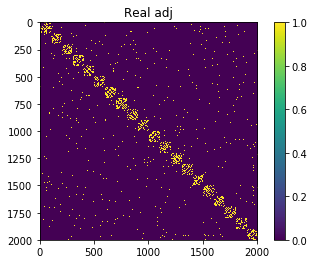

In [7]:
fig_adj, ax_adj = plt.subplots()
im_adj = ax_adj.imshow(next(iter_results())[-1]['adj'].todense())
ax_adj.set_title('Real adj')
plt.colorbar(im_adj, ax=ax_adj);

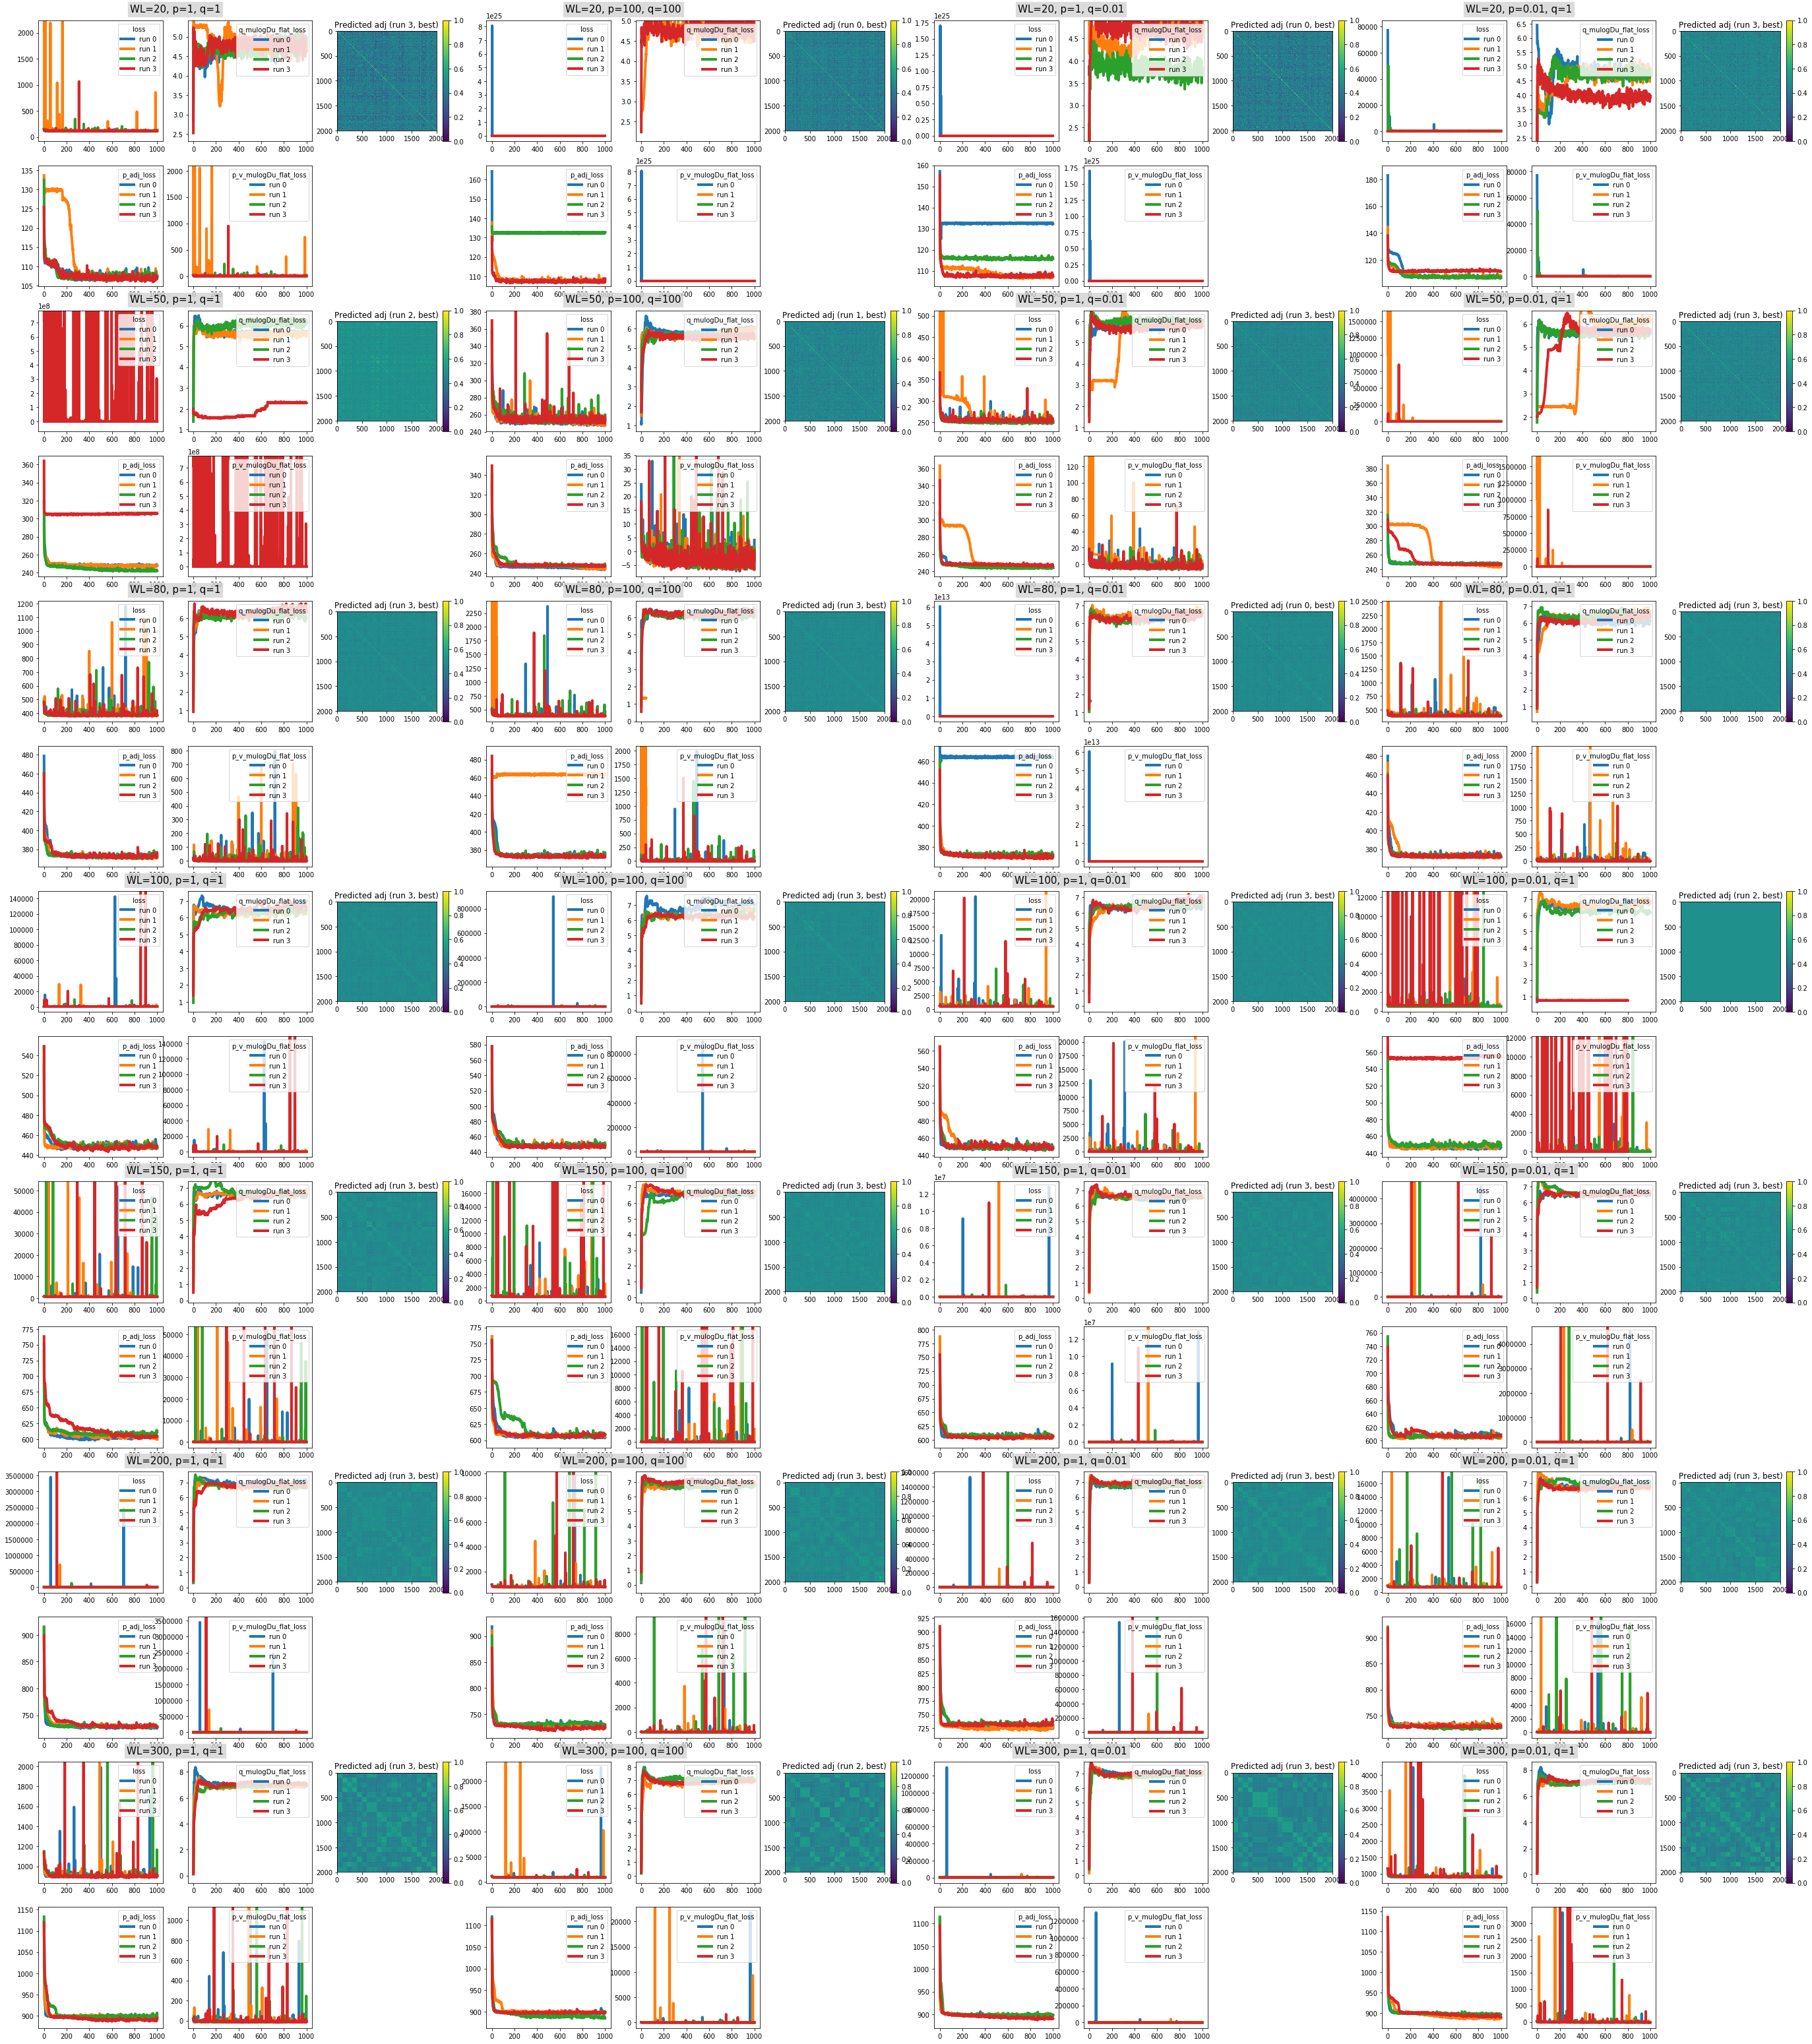

In [8]:
figscale = 8
fig, axes = plt.subplots(2 * len(grid_max_walk_length), 3 * len(grid_pq),
                         figsize=((3/2) * len(grid_pq) * figscale, len(grid_max_walk_length) * figscale))

best_adj_run = None
best_adj_loss = None
for (i, max_walk_length), (j, (p, q)), run, results in iter_results():
    history_plot_kws = {'lw': 4}
    plot_history(results['history'], axes[i*2:i*2 + 2, j*3:j*3 + 2].flatten(), run,
                 plot_kws=history_plot_kws)
    if best_adj_loss is None or results['history']['p_adj_loss'][-1] < best_adj_loss:
        best_adj_run = run
        best_adj_loss = results['history']['loss'][-1]
        best_adj_pred = results['adj_pred']
    if run == n_runs - 1:
        plot_adj(best_adj_pred, axes[i*2, j*3 + 2], im_adj, 'Predicted adj (run {}, best)'.format(best_adj_run))
        axes[i*2 + 1, j*3 + 2].set_visible(False)
        axes[i*2, j*3].text(1.1, 1.05, 'WL={}, p={}, q={}'.format(max_walk_length, p, q),
                            ha='center', va='bottom',
                            transform=axes[i*2, j*3].transAxes,
                            bbox=dict(facecolor='lightgrey', alpha=0.8, edgecolor='white'),
                            fontsize=15)
        best_adj_run = None
        best_adj_loss = None